# This is the notebook for the code implementing a Simple CNN model

Because CNN implementations were not taught during class, most of this code was generated using ChatGPT, but I added in code based on concepts from the class to help make it more understandable (metrics and calculations, plots, etc.).

# 1. Imports and creating the Simple CNN model.

For imports, I needed to use os (to interact with computer's os), numpy (for calculations), cv2 (for computer vision and image processing), matplotlib (for our plots), seaborn (for our confusion matrix), torch (since we decided against tensorflow), torch.nn, torch.nn.functional, torch.utils.data, torchvision, and sklearn.metrics to gather the metrics we wanted to compare between models.

In [ ]:
# imports
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Simple CNN model implementation
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# needed to resize all the images in the dataset to avoid errors
IMG_SIZE = 224

# 2. Handling the Dataset.

We needed to ensure that the YOLO label format was handled correctly, implementing these functions to do so.

In [ ]:
# get the images from the dataset
class BrainTumorClassificationDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform

        # find the images that have matching YOLO label files
        self.img_files = [
            f for f in os.listdir(img_dir)
            if f.endswith(".jpg") and os.path.exists(
                os.path.join(label_dir, f.replace(".jpg", ".txt"))
            )
        ]

        # check if images do not have a matching label
        if len(self.img_files) == 0:
            raise RuntimeError(f"No images found with labels in: {img_dir}")

        # assign class names depending on the label text (the first integer represents tumor or no tumor with 0 and 1)
        self.class_names = ["no tumor", "tumor"]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]

        # load the image
        img_path = os.path.join(self.img_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # apply transforms
        if self.transform:
            image = self.transform(image)

        # read the YOLO class label (first integer)
        label_path = os.path.join(self.label_dir, img_name.replace(".jpg", ".txt"))
        with open(label_path, "r") as f:
            line = f.readline().strip().split()
            # give class name
            class_idx = int(line[0])  

        return image, class_idx


# 3. Transform, and assign paths.

Using our IMG_SIZE, resize the images, and with our given dataset, assign the paths to the images and labels.

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_imgs = "archive/brain-tumor/train/images"
train_labels = "archive/brain-tumor/train/labels"

val_imgs = "archive/brain-tumor/valid/images"
val_labels = "archive/brain-tumor/valid/labels"


# 4. Load the data.

Using the functions we assigned earlier, load the data, checking that all the iages have proper annotations. We ended up using slightly less than the amount of images provided by the dataset since not all had labels.

In [ ]:
train_dataset = BrainTumorClassificationDataset(train_imgs, train_labels, transform)
val_dataset = BrainTumorClassificationDataset(val_imgs, val_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print("Train samples:", len(train_dataset))
print("Valid samples:", len(val_dataset))

Train samples: 878
Valid samples: 223


# 5. Train the model.

Using our predefined model, we run it on the dataset.

In [ ]:
# sanity checks
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=2).to(device)

# working with cross entropy loss as one of our metrics
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# using more than 10 epochs for good training
EPOCHS = 12

# gathering loss for both train and validations sets.
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # train!
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)

    # add to losses
    train_losses.append(running_loss / len(train_dataset))

    # validation
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)

            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # add to losses
    val_losses.append(val_loss / len(val_dataset))
    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f} - Val Acc: {acc:.4f}")

# gather metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(classification_report(all_labels, all_preds))
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1:", f1)


Epoch 1/12 - Train Loss: 0.6907 - Val Loss: 0.7318 - Val Acc: 0.3677
Epoch 2/12 - Train Loss: 0.6704 - Val Loss: 0.7135 - Val Acc: 0.3991
Epoch 3/12 - Train Loss: 0.6226 - Val Loss: 0.8307 - Val Acc: 0.3722
Epoch 4/12 - Train Loss: 0.5906 - Val Loss: 0.6887 - Val Acc: 0.5426
Epoch 5/12 - Train Loss: 0.5141 - Val Loss: 0.7060 - Val Acc: 0.5605
Epoch 6/12 - Train Loss: 0.4467 - Val Loss: 0.8144 - Val Acc: 0.5561
Epoch 7/12 - Train Loss: 0.3983 - Val Loss: 0.7268 - Val Acc: 0.5561
Epoch 8/12 - Train Loss: 0.3464 - Val Loss: 0.8712 - Val Acc: 0.5561
Epoch 9/12 - Train Loss: 0.3218 - Val Loss: 0.9982 - Val Acc: 0.5695
Epoch 10/12 - Train Loss: 0.2737 - Val Loss: 0.8782 - Val Acc: 0.5874
Epoch 11/12 - Train Loss: 0.2664 - Val Loss: 0.9510 - Val Acc: 0.5785
Epoch 12/12 - Train Loss: 0.2049 - Val Loss: 1.1765 - Val Acc: 0.5785
              precision    recall  f1-score   support

           0       0.73      0.54      0.62       142
           1       0.45      0.65      0.53        81

    a

# 6. Confusion Matrix.

From our gathered metrics and the skitlearn library, we generate a confusion matrix to depict our results.

[[76 66]
 [28 53]]


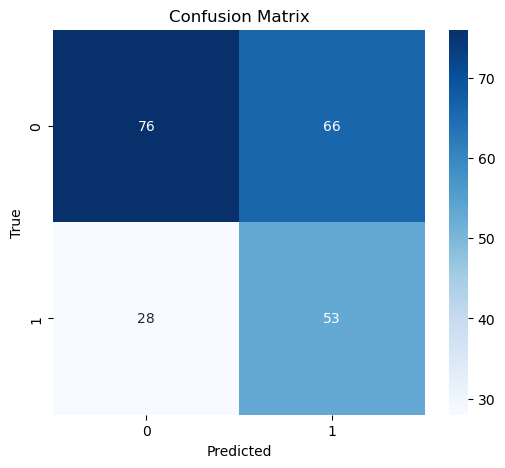

In [ ]:
all_preds = []
all_labels = []

# set the model to evaluation mode
model.eval()  
with torch.no_grad():
    for i in range(len(val_dataset)):
        img, label = val_dataset[i]

        # add the batch dimension, and move to the device
        img_tensor = img.unsqueeze(0).to(device)

        output = model(img_tensor)
        pred = output.argmax(1).item()

        all_preds.append(pred)
        all_labels.append(label)

# get the matrix
cm = confusion_matrix(all_labels, all_preds)
print(cm)

class_names = val_dataset.class_names  # ["glioma", "meningioma", "pituitary"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 7. Loss Plots.

Using matplotlib, we were able to plot our loss over each epoch.

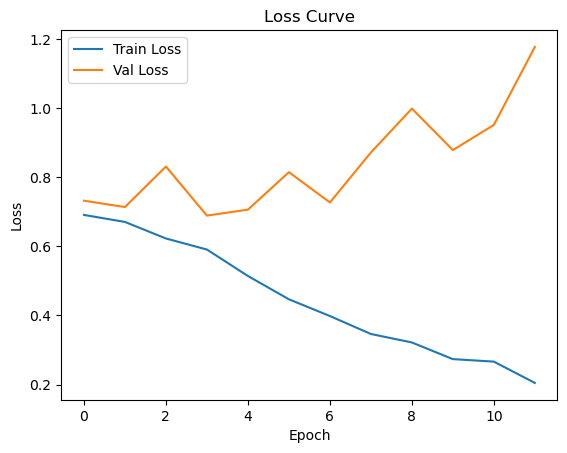

In [ ]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 8. Visualize with Grad-CAM.

Using our function and our images, we gather the heatmaps for identifying the tumors based on the trained model.

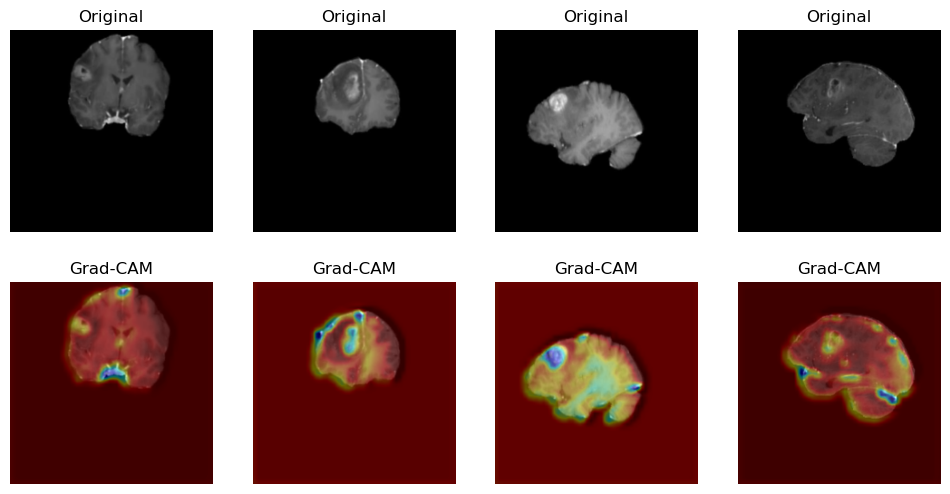

In [ ]:
# specifically a batch gradcam
def gradcam_batch(model, images, target_layer):
    model.eval()
    gradients = []
    activations = []

    # forward hook
    def fw_hook(module, inp, out):
        activations.append(out.detach())
    # backward hook
    def bw_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    handle_fw = target_layer.register_forward_hook(fw_hook)
    handle_bw = target_layer.register_backward_hook(bw_hook)

    cams = []
    for img in images:
        img = img.unsqueeze(0).to(device)
        output = model(img)
        target_class = output.argmax(1).item()
        loss = output[0, target_class]
        model.zero_grad()
        loss.backward()

        # use the gradient, activation, and weights to get cam
        gradient = gradients[0]
        activation = activations[0]
        weights = gradient.mean(dim=[2,3], keepdim=True)
        cam = (weights * activation).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
        cam = cam - cam.min()
        cam = cam / cam.max()
        cams.append(cam)

        gradients.clear()
        activations.clear()

    handle_fw.remove()
    handle_bw.remove()
    return cams

# overlay
def overlay_cam(image_tensor, cam):
    img = image_tensor.permute(1,2,0).cpu().numpy()
    img = np.uint8(255 * (img - img.min()) / (img.max() - img.min()))
    heatmap = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    return overlay

# show the batch Grad-CAM for the first 4 validation images
images_batch = [val_dataset[i][0] for i in range(4)]
cams = gradcam_batch(model, images_batch, model.conv3)

plt.figure(figsize=(12,6))
for i, img in enumerate(images_batch):
    plt.subplot(2,4,i+1)
    plt.imshow(img.permute(1,2,0))
    plt.axis("off")
    plt.title("Original")

    plt.subplot(2,4,i+5)
    overlay = overlay_cam(img, cams[i])
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Grad-CAM")
plt.show()


# Extra: Misclassified images.

Gather the images that were misclassified to see what type of errors the model was most prone to.

In [ ]:
misclassified = []

# go through the validation dataset
for i in range(len(val_dataset)):
    img, label = val_dataset[i]

    # add the batch dimension, and move to the device
    img_tensor = img.unsqueeze(0).to(device)

    # forward pass
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(1).item()

    if pred != label:
        misclassified.append((img, label, pred))

    # stop after 9 misclassified images for now
    if len(misclassified) >= 9:
        break

# visualize them
plt.figure(figsize=(10,10))
for i, (img, label, pred) in enumerate(misclassified):
    plt.subplot(3,3,i+1)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"True: {val_dataset.class_names[label]}\nPred: {val_dataset.class_names[pred]}")
    plt.axis("off")
plt.show()
